In [16]:
%matplotlib inline

import numpy as np 
import os 
import sys 

import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
#import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
from crick import TDigest as TDigestCrick
import requests
import aiohttp
#from httpfs import HTTPFileSystem


path = "/home/b/b382291/git/one_pass"
sys.path.append(path)
os.chdir(path)

from one_pass.opa import *
from one_pass.opa import Opa

path = "/home/b/b382291/git/AQUA"
sys.path.append(path)
os.chdir(path)
from aqua import Reader 

! hostname

l40347.lvt.dkrz.de


In [18]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

In [17]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
ds = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_1h_native'].to_dask() # load medium-resolution here, monthly means
ds_u100 = ds['100u']
ds_v100 = ds['100v']
ds = np.sqrt(ds_u100**2 + ds_v100**2)

In [32]:
# take 1 time step
ds_ll = ds.pipe(attach_coords).isel(value=0)
ds_ll

<xarray.DataArray (time: 43394)>
dask.array<getitem, shape=(43394,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 89.97
    lon      float64 0.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Attributes: (12/15)
    paramId:                    228246
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       100 metre U wind component
    cfVarName:                  u100
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

Going to select one spatial location 

In [54]:
# call into memory 
data = ds_ll[0:10].values

data = data.astype('float64')

print(data.itemsize)

sys.getsizeof(data) #/(10**6)


8


192

In [56]:
ds_ll.time

<xarray.DataArray 'time' (time: 43394)>
array(['2020-01-20T00:00:00.000000000', '2020-01-20T01:00:00.000000000',
       '2020-01-20T02:00:00.000000000', ..., '2024-12-31T22:00:00.000000000',
       '2024-12-31T23:00:00.000000000', '2025-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    lat      float64 89.97
    lon      float64 0.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01

In [63]:
ds_ll[6].values

array(6.55067396)

 99%|█████████▉| 119/120 [02:13<00:01,  1.22s/it]

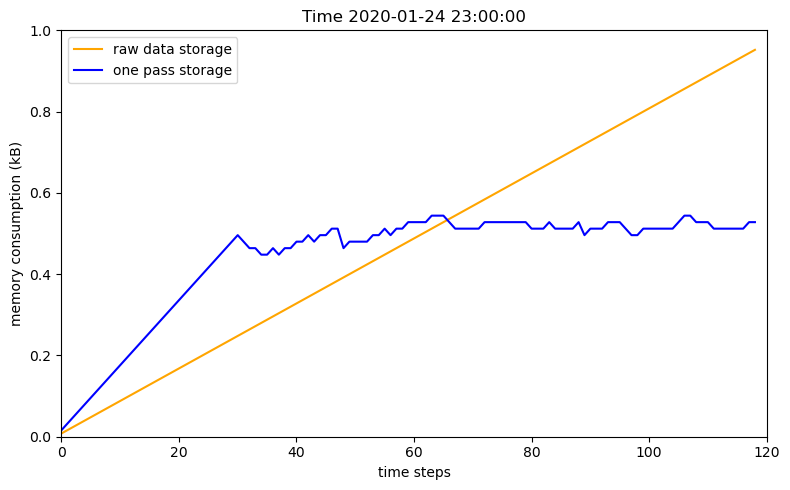

100%|██████████| 120/120 [02:15<00:00,  1.13s/it]


In [116]:
import tqdm 

#wpd = (0.5*1.225*time_series**3)/1000

# looking at using capacity factor calculated above 

time_series = ds_ll

#bins_space = np.linspace(0, 1, 30)
#u_1d = np.resize(data_sample, np.size(data_sample))

n = 5*24 # np.size(time_series)

y1 = np.zeros(n)
y2 = np.zeros(n)
loaded_data = np.zeros(n)
x = np.zeros(n)

dictlist = [dict() for x in range(n)]    
digest = TDigestCrick(compression = 25) 

tvec = np.arange(np.datetime64('2020-01-20'), np.datetime64('2025-01-20'),dtype='datetime64[h]')

# looking over 5 days
for i in tqdm.tqdm(range(n)):
    
    # call the same function with different data in parallel
    new_value = time_series[i].values
    digest.update(new_value)
    
    if i == 0 : 
        loaded_data[i] = new_value
        #y1[i] = sys.getsizeof(new_value)/(10**3)        
        y1[i] = 8/(10**3)        
    else: 
        y1[i] = y1[i-1] + 8/(10**3)
    
    y2[i] = (np.size(digest.centroids())*2*8)/(10**3)
    x[i] = i
        
    if (i == n-1):
        
        ylimit = 1 
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(x[0:i], y1[0:i], label='raw data storage', color = 'orange')
        ax.plot(x[0:i], y2[0:i], label='one pass storage')
        ax.set_title(f'Time {pd.Timestamp(tvec[i])}')
        ax.set_xlabel('time steps')
        ax.set_ylabel('memory consumption per grid cell (kB)')
        ax.set_ylim([0, ylimit])
        ax.set_xlim([0, n])
        ax.legend()

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

In [111]:
print(np.size(digest.centroids())*2*8)
print(sys.getsizeof(digest.centroids()))
np.size(digest.centroids())


480
592


30

In [104]:
loaded_data[0:8].itemsize
sys.getsizeof(loaded_data[0:8])
sys.getsizeof(new_value)
#loaded_data

104

MovieWriter Pillow unavailable; using Pillow instead.


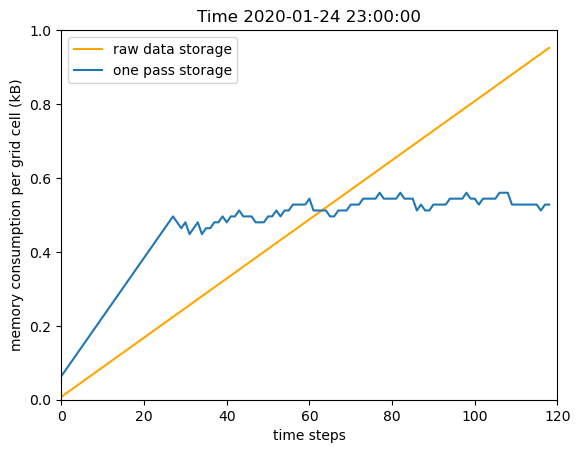

In [137]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

n = 5*24 # np.size(time_series)

frame_data = ds_ll[0:n]

#bins_space = np.linspace(0, 1, 30)
#u_1d = np.resize(data_sample, np.size(data_sample))

y1 = np.zeros(n)
y2 = np.zeros(n)
loaded_data = np.zeros(n)
x = np.zeros(n)
i = 0 
ylimit = 1 

digest = TDigestCrick(compression = 25) 
tvec = np.arange(np.datetime64('2020-01-20'), np.datetime64('2025-01-20'),dtype='datetime64[h]')
fig, ax = plt.subplots()

def update(frame):
    
    ax.clear()  # Clear the previous frame
    # call the same function with different data in parallel
    new_value = frame_data[frame].values
    digest.update(new_value)
    
    if frame == 0 : 
        loaded_data[i] = new_value
        #y1[i] = sys.getsizeof(new_value)/(10**3)        
        y1[frame] = 8/(10**3)        
    else: 
        y1[frame] = y1[frame -1] + 8/(10**3)
    
    y2[frame] = (np.size(digest.centroids())*2*8)/(10**3)
    x[frame] = frame 
    
    #fig, ax = plt.subplots(figsize=(8, 5))
    patches = ax.plot(x[0:frame], y1[0:frame], label='raw data storage', color = 'orange')
    ax.plot(x[0:frame], y2[0:frame], label='one pass storage')
    ax.set_title(f'Time {pd.Timestamp(tvec[frame])}')
    ax.set_xlabel('time steps')
    ax.set_ylabel('memory consumption per grid cell (kB)')
    ax.set_ylim([0, ylimit])
    ax.set_xlim([0, n])
    ax.legend()

    return patches  # Return the modified patches

animation = FuncAnimation(fig, update, frames=len(frame_data), interval=100, blit=True)

#file_path = '/home/b/b382291/git/one_pass/histogram_wind_speed.gif'
file_path = '/home/b/b382291/git/one_pass/memory_consumption.gif'
animation.save(file_path, writer='Pillow', fps=6.25)